# Visión por Computadora I - 2025 - B3 - Trabajo práctico 2
**Inteligencia Artificial - CEIA - FIUBA**

## Autores

- **Mealla Pablo**.
- **Mendoza Dante**.
- **Vasquez Jorge**.
- **Viñas Gustavo**.

# 💻 TP2 - Objetivo

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas.  
El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Área de la ROI = 5 o 10% del área total del frame.
    3. (Opcional) Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)  
  
    Para cada experimento se debe presentar :
      - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shape from focus.  
3. (Puntos extra) Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### 1. Implementación del algoritmo

In [2]:
def image_quality_measure(I: np.ndarray) -> float:
    """
    Calculate image quality measure

    Parameters
    ---------
    I (np.ndarray)
        Source image
    
    Returns
    ---------
    FM (float)
        Image Quality Measure for input image
    """
    if (I.ndim != 2): raise Exception("Only 2D (gray) images allowed.")
    # step 1 - compute fast fourier transform (fft) representation of source image
    F = np.fft.fft2(I)
    # step 2 - shift origin of fft to centre
    Fc = np.fft.fftshift(F)
    # step 3 - calculate absolute value of the centered fft
    AF = np.abs(Fc)
    # step 4 - calculate max value of absolute fft
    M = np.max(AF)
    # step 5 - calculate threshold and total number of pixels in fft image whose pixel value is above threshold
    thres = M / 1000
    T_h = sum(1 for p in AF.ravel() if p > thres) ## Duda si aca va AF o F (según el paper indica F, pero nos hace mas sentido que sea AF). (Según pruebas sobre lena, es AF)
    FM = T_h / (I.shape[0] * I.shape[1])
    return FM

In [3]:
# Test algorithm 
img_lena = cv2.imread('./img/lena_std.tif', cv2.IMREAD_GRAYSCALE)
print(f"Lena IQM (FM): {image_quality_measure(img_lena):.4f}")


Lena IQM (FM): 0.0182


Funciones para el procesamiento del video y gráfico

In [4]:
from collections.abc import Callable
def process_video(video_path: str, frame_func: Callable[[np.ndarray], float]) -> list[float]:
    video = cv2.VideoCapture(video_path)
    if not video.isOpened(): raise Exception("Error al abrir el archivo de video")

    try:
        res_array = []
        while True:
            ret, frame = video.read()
            if not ret: break
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            single_frame_res = frame_func(frame_gris)
            res_array.append(single_frame_res)
        
        return res_array
    finally:
        video.release()

def plot_comparative(elements: list[list[float]], labels: list[str], figsize: list[int], colors: list[str]):
    plt.figure(figsize=figsize)
    axn=plt.subplot(212)
    for x in range(len(elements)):
        ax=plt.subplot(200 + len(elements) * 10 + x + 1)
        ax.plot(elements[x], marker='o', linestyle='', color=colors[x])
        max_frame = int(np.argmax(elements[x]))
        ax.axvline(max_frame, color=colors[x])
        ax.text(max_frame, ax.get_ylim()[0], str(max_frame))
        ax.text(max_frame, elements[x][max_frame], f"{elements[x][max_frame]:.3f}")
        ax.set_xlabel("Frame #")
        ax.set_ylabel("IQM (FM)")
        ax.set_title(label=labels[x])
        ax.grid(True)

        axn.plot(elements[x], marker='o', linestyle='', color=colors[x], label=labels[x])
        axn.axvline(max_frame, color=colors[x])
        axn.text(max_frame, axn.get_ylim()[0], str(max_frame))
        axn.text(max_frame, elements[x][max_frame], f"{elements[x][max_frame]:.3f}")
    axn.set_xlabel("Frame #")
    axn.set_ylabel("IQM (FM)")
    axn.set_title(r"ROI comparative")
    axn.legend()
    axn.grid(True)

>  1. Medición sobre todo el frame

In [5]:
def full_frame_analysis(frame: np.ndarray) -> float:
    return image_quality_measure(frame)

In [6]:
video_path = "./video/focus_video.mov"
full_frame_iqm = process_video(video_path, full_frame_analysis)

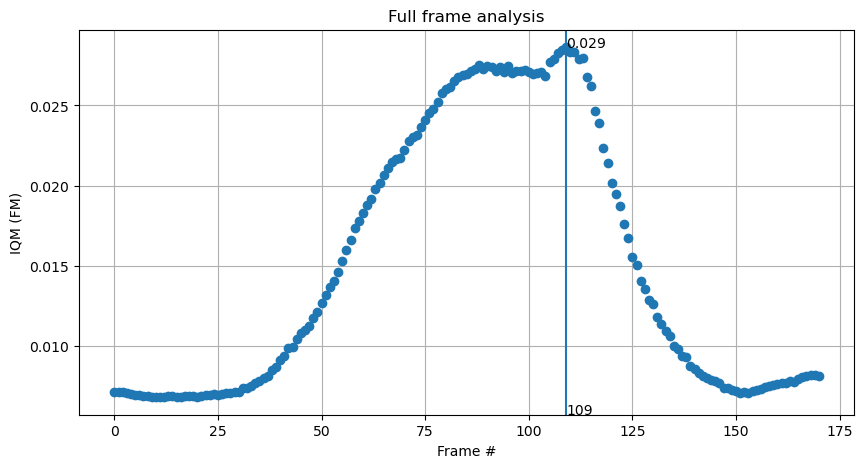

In [7]:
plt.figure(figsize=(10,5))
plt.plot(full_frame_iqm, marker='o', linestyle='')
max_frame = int(np.argmax(full_frame_iqm))
plt.axvline(max_frame)
plt.text(max_frame, plt.ylim()[0], str(max_frame))
plt.text(max_frame, full_frame_iqm[max_frame], f"{full_frame_iqm[max_frame]:.3f}")
plt.xlabel("Frame #")
plt.ylabel("IQM (FM)")
plt.title("Full frame analysis")
plt.grid(True)
plt.show()

>  2. Medición sobre una ROI centrada de 10% y 5%

In [8]:
def roi_frame_analysis(frame: np.ndarray, roi: float) -> float:
    if roi > 1 or roi <= 0: raise Exception("roi value must be greater than 0 and less than 1")
    frame_width = frame.shape[1]
    roi_width = int(frame_width * roi)
    roi_x = frame_width // 2 - roi_width // 2
    frame_height = frame.shape[0]
    roi_height = int(frame_height * roi)
    roi_y = frame_height // 2 - roi_height // 2
    return image_quality_measure(frame[roi_y:roi_y+roi_height,roi_x:roi_x+roi_width])

In [9]:
roi_frame_iqm = []
video_path = "./video/focus_video.mov"
roi_frame_iqm.append(process_video(video_path, lambda frame: roi_frame_analysis(frame, 0.1)))
roi_frame_iqm.append(process_video(video_path, lambda frame: roi_frame_analysis(frame, 0.05)))
roi_frame_iqm.append(process_video(video_path, lambda frame: roi_frame_analysis(frame, 1))) # Debe dar el mismo resultado que el punto 1

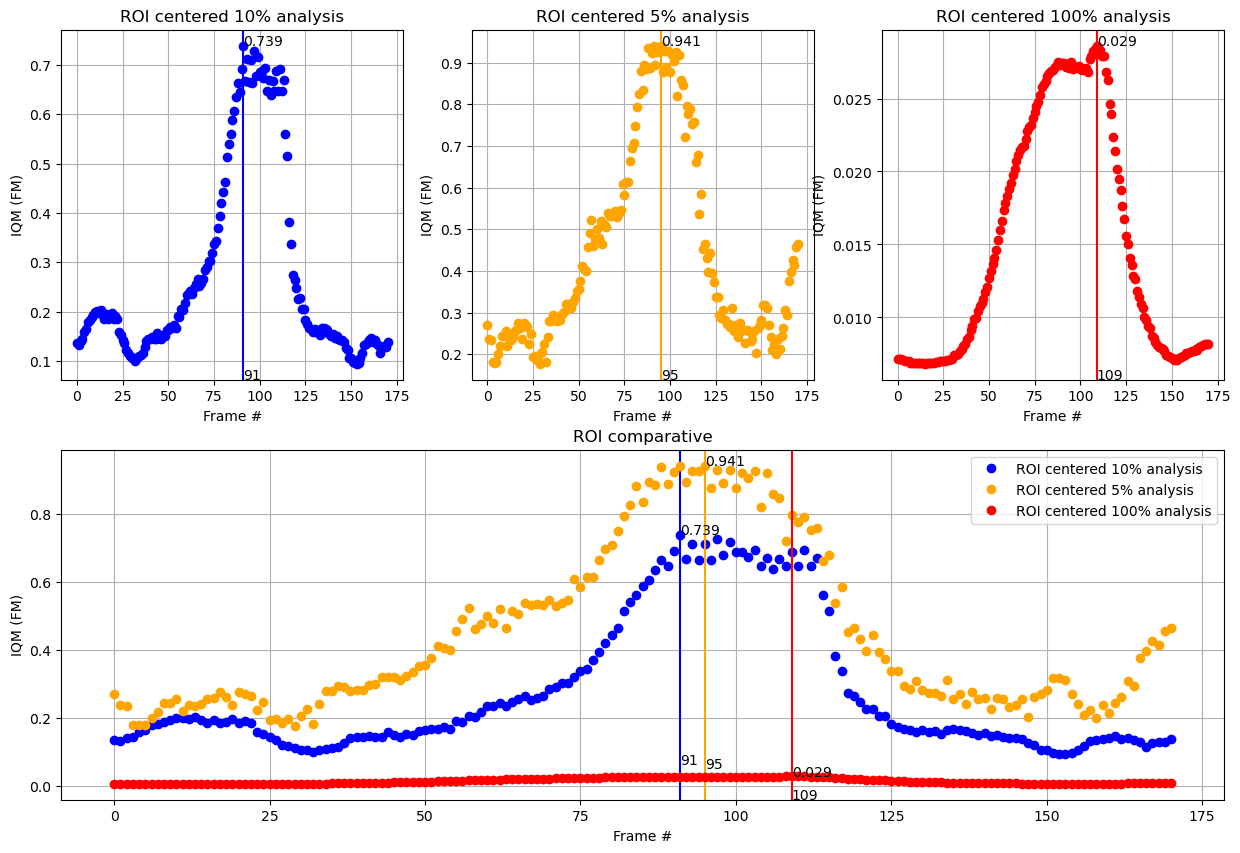

In [10]:
colors = ["blue", "orange", "red"]
plot_comparative(roi_frame_iqm, [r"ROI centered 10% analysis", r"ROI centered 5% analysis", r"ROI centered 100% analysis"], [15,10], colors)

>  3. Medición sobre una matriz de enfoque de NxM

In [11]:
video_path = "./video/focus_video.mov"

def matrix_frame_analysis(frame: np.ndarray, matrix_n: int, matrix_m: int, roi: float, space: float) -> float:
    if matrix_n < 1 or matrix_m < 1: raise Exception("m and n must be greater or equal than 1")
    if roi > 1 or roi <= 0: raise Exception("roi value must be greater than 0 and less than 1")
    if space > 0.1 or space <= 0: raise Exception("space value must be greater than 0 and less than 0.1")

    if (matrix_n * roi + (matrix_n - 1) * space) > 1: raise Exception("n*roi+(n-1)*space must be <= 1")
    if (matrix_m * roi + (matrix_m - 1) * space) > 1: raise Exception("m*roi+(m-1)*space must be <= 1")
    
    frame_width = frame.shape[1]
    roi_width = int(frame_width * roi)
    space_width = int(frame_width * space)
    roi_size_n = roi_width * matrix_n
    space_size_n = space_width * (matrix_n - 1)
    start_x = frame_width // 2 - roi_size_n // 2 - space_size_n // 2

    frame_height = frame.shape[0]
    roi_height = int(frame_height * roi)
    space_height = int(frame_height * space)
    roi_size_m = roi_height * matrix_m
    space_size_m = space_height * (matrix_m - 1)
    start_y = frame_height // 2 - roi_size_m // 2 - space_size_m // 2

    frame_iqm = []
    for n in range(matrix_n):
        x = start_x + n * (roi_width + space_width)
        for m in range(matrix_m):
            y = start_y + m * space_height
            frame_iqm.append(image_quality_measure(frame[y:y+roi_height,x:x+roi_width]))
    
    return float(np.mean(frame_iqm))

In [12]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, lambda frame: matrix_frame_analysis(frame, matrix_n=1, matrix_m=1, roi=0.1, space=0.01))) # Debe dar el mismo resultado que el punto 2 para roi 0.1
matrix_frame_iqm.append(process_video(video_path, lambda frame: matrix_frame_analysis(frame, matrix_n=1, matrix_m=1, roi=0.05, space=0.01))) # Debe dar el mismo resultado que el punto 2 para roi 0.05
matrix_frame_iqm.append(process_video(video_path, lambda frame: matrix_frame_analysis(frame, matrix_n=1, matrix_m=1, roi=1, space=0.01))) # Debe dar el mismo resultado que el punto 1
# El gráfico obtenido debería ser igual al punto anterior, solo para verificación

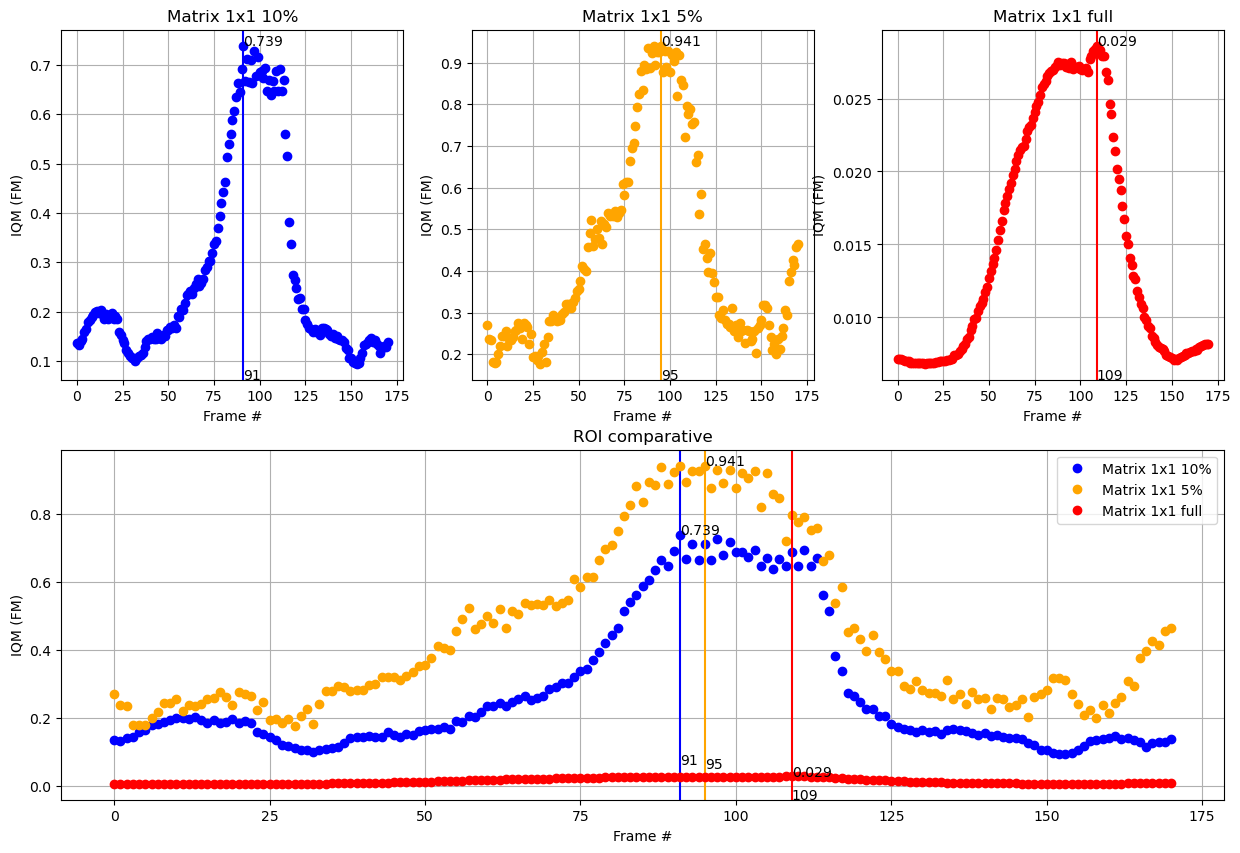

In [13]:
colors = ["blue", "orange", "red"]
plot_comparative(matrix_frame_iqm, [r"Matrix 1x1 10%", r"Matrix 1x1 5%", r"Matrix 1x1 full"], [15,10], colors)


In [14]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, lambda frame: matrix_frame_analysis(frame, matrix_n=3, matrix_m=3, roi=0.05, space=0.01)))
matrix_frame_iqm.append(process_video(video_path, lambda frame: matrix_frame_analysis(frame, matrix_n=7, matrix_m=5, roi=0.05, space=0.01)))


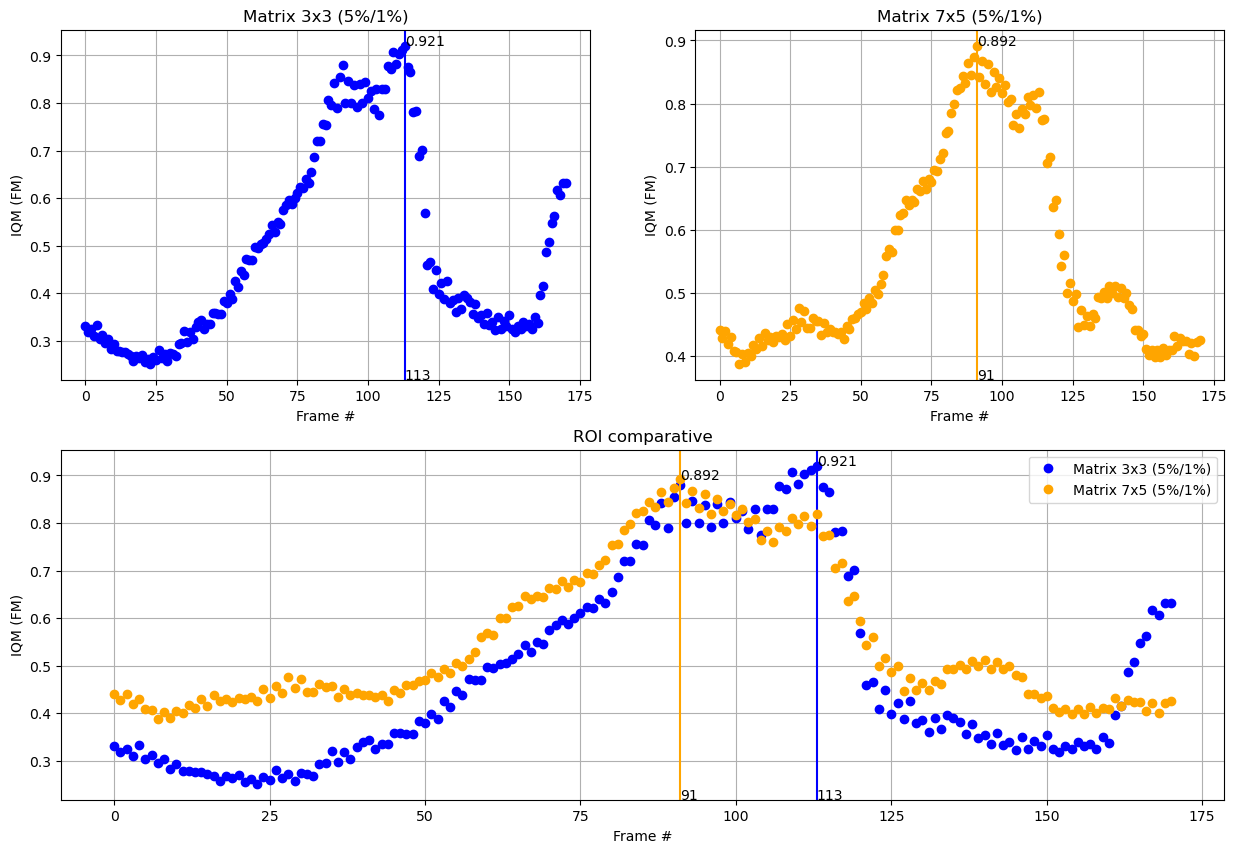

In [15]:
colors = ["blue", "orange", "red", "green"]
plot_comparative(matrix_frame_iqm, [r"Matrix 3x3 (5%/1%)", r"Matrix 7x5 (5%/1%)"], [15,10], colors)